## Part 2: Regression

The [NO2 dataset](https://www.openml.org/d/547) contains 500 measurement of pollution caused by cars. The goal is to predict the concentration of $NO_2$ from data about traffic and atmospheric conditions. The predictive variables include the number of cars per hour, temperature, wind, and time of day.

In [19]:
# General imports
from sklearn.model_selection import cross_validate, train_test_split
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
from matplotlib import cm

# Library to show progress bars for iterables
from tqdm import tqdm

In [20]:
# Download NO2 data. Takes a while the first time.
no2 = oml.datasets.get_dataset(547)
X, y, _, _ = no2.get_data(target=no2.default_target_attribute);
attribute_names = list(X)

## Quick visualization
We can use pandas to quickly visualize the data. If you are new to pandas, take some time to understand the code.

We'll remove the 'day' feature to focus on the non-temporal aspects of this interaction. We are not aiming to predict future levels, and even if we would it would require special treatment (e.g. different train-test splits). There also doesn't seem to be a long term trend in the data, even though there are clear periodic trends in temperature.

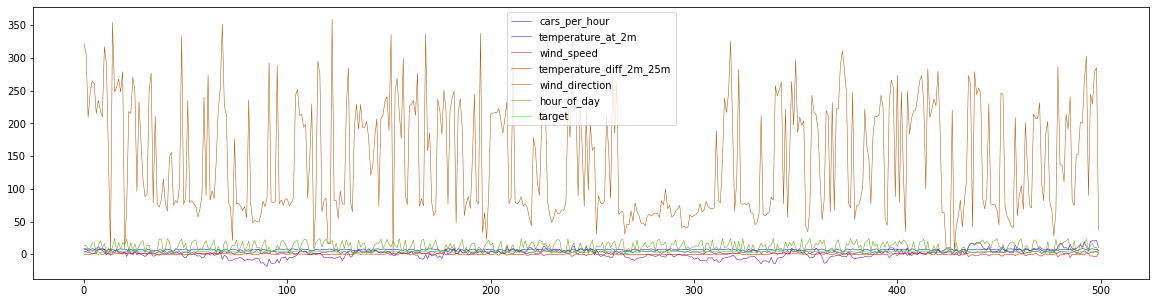

In [21]:
df = pd.DataFrame(X, columns=attribute_names).join(pd.DataFrame(list(y),columns=['target']))
df = df.sort_values(['day','hour_of_day']).drop('day',axis=1)
df.plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));
X = X.drop('day',axis=1)

In [22]:
df.head()

,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,target
42,7.64,8.5,4.3,-0.2,322.0,13,3.22
20,7.75,8.2,4.5,0.2,307.0,14,3.15
255,8.12,5.2,2.8,0.3,209.0,8,4.20
488,7.64,6.7,2.3,-0.4,247.0,10,3.98
94,8.32,6.3,1.2,1.3,265.0,17,4.14


If we plot the data, ordered by time of measurement, we can see that the wind direction (measured in angular degrees) is scaled very differently from the other features. Let's now zoom in to the other measures:

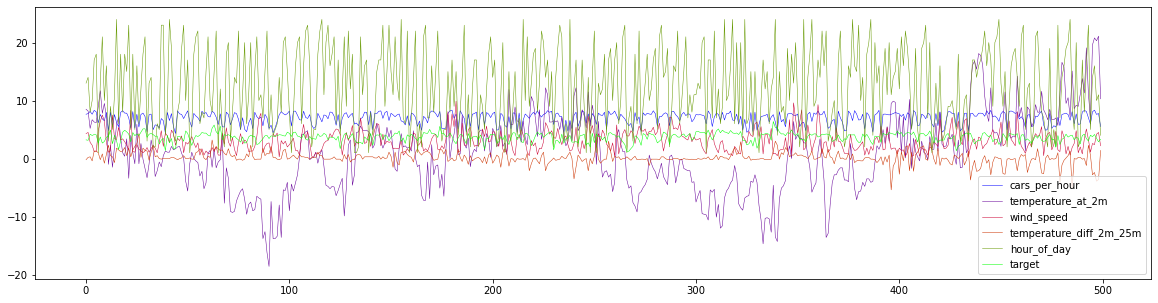

In [23]:
df.drop('wind_direction',axis=1).plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));

We can see that the target ($NO_2$ levels) seem to be correlated to the number of cars per hour, which makes sense because cars produce $NO_2$. Other influences (air temperature differences and wind) seem to have a more complex and subtle effect. Let's try to model these using linear regression models.

## Exercise 1: Model benchmark
It is clear that $NO_2$ concentrations depend on a combination of these features, so we will now try to learn this complex relationship. We first evaluate a range of linear regression problems, i.e. Linear Regression, Ridge, Lasso and ElasticNet, as well as kNN. Since we observed that somf features have very different scales, we'll also build pipelines of all these measures with an additional scaling step. For now, we'll stick to the default hyperparameter settings.

### Exercise 1.1
Implement a function below which evaluates each ?classifier? passed into it on the given data, and then returns both the train and test scores of each as a list. You are allowed to import additional functions from whichever module you like, but you should be able to complete the function with [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function and standard Python built-ins. Below you the function you will find example output.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="400" />

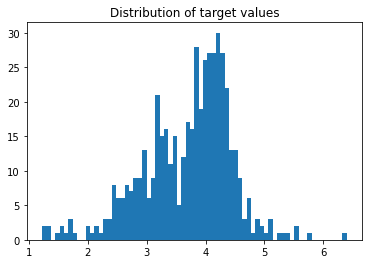

In [24]:
plt.title("Distribution of target values")
plt.hist(y, bins=70);

In [25]:
def evaluate_learners(models, X, y):
    """
    Given a list of models [model1, model2, ..., modelN] return two lists:
     - a list with the scores obtained on the training samples for each model,
     - a list with the test scores obtained on the test samples for each model.
     The order of scores should match the order in which the models were originally provided. E.g.:
     [Model1 train score, ..., ModelN train score], [Model1 test score, ..., ModelN test score]
    """
    train_scores, test_scores = [], []

    for model in models:
        model.fit(X, y)
        results = cross_validate(model, X, y, return_train_score=True, n_jobs=-1)
        train_scores.append(results["train_score"])
        test_scores.append(results["test_score"])

    return train_scores, test_scores

### Exercise 1.2
Call the function you created with a Linear Regression, Ridge, Lasso and ElasticNet, as well as kNN.
Store the return values in the variables `train_scores` and `test_scores`. Then, run the code given below to produce a plot visualizing the scores.

In [26]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

# Generate the train/test split
# X_train, X_test, y_train, y_test \
#     = train_test_split(X,y, random_state=1)

# Create and evaluate the modelss
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), KNeighborsRegressor()]
train_scores, test_scores = evaluate_learners(models, X, y)

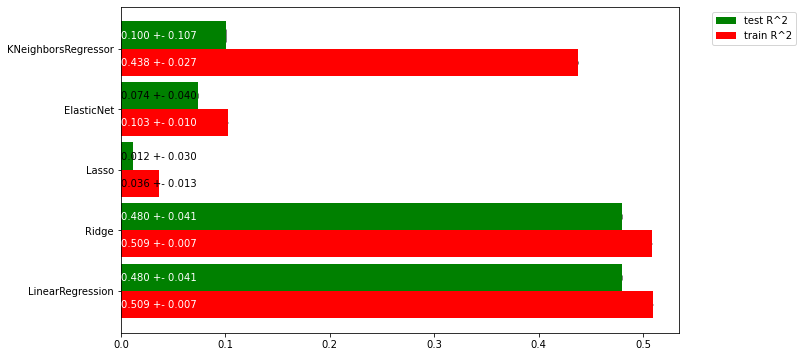

In [27]:
# Plot a bar chart of the train and test scores of all the classifiers, including the variance as error bars
fig, ax = plt.subplots(figsize=(10,6))
width=0.45

ax.barh(np.arange(len(train_scores)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test R^2')
ax.barh(np.arange(len(train_scores))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train R^2')
for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
    ax.text(0, i, "{:.3f} +- {:.3f}".format(np.mean(te),np.std(te)), color=('white' if np.mean(te)>0.1 else 'black'), va='center')
    ax.text(0, i-width, "{:.3f} +- {:.3f}".format(np.mean(tr),np.std(tr)), color=('white' if np.mean(tr)>0.1 else 'black'), va='center')
labels = [c.__class__.__name__ if not hasattr(c, 'steps') else c.steps[0][0] + "_" + c.steps[1][0] for c in models]
ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=labels)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

### Exercise 1.3
Interpret the plot. _$R^2$ is the portion of the variance that can be explained by the input variabels_

**Test and train labels/colors in the plot are wrongly coded**

* Which is the best regressor?

LinearRegression and Ridge have the highest R^2 and show almost no overfitting so the are candidates for the best models.

ElasticNet and Lassa are not that much overfitting but have a very low R^2 score which makes them not usefull with their default parameters.

* Are any of the models overfitting?

KNeighborsRegressor is strongly overfitting.

* If so, what can we do to solve this?

Tweak the parameters.

* Is there a lot of variance in the results?

Yes, almost all models behave differently

## Exercise 2: Regularization
We will now tune these algorithm's main regularization hyperparameter: the regularization hyperparameter (`alpha`) in Lasso and Ridge, and the number of neighbors (`n_neighbors`) in kNN.

We expect the optimum for the alpha parameters to lie in $[10^{-12},10^{12}]$ and for n_neighbors between 1 and 50. alpha should be varied on a log scale (i.e. [0.01, 0.1, 1, 10, 100]), n_neighbors should be varied uniformly (i.e. [1,2,3,4]).

### Exercise 2.1
Vary the hyperparameters in the range given above and, for each regressor, create a line plot that plots both the training and test score for every value of the regularization hyperparameter. Hence, you should produce 3 plots, one for each regressor. Use the default 5-fold cross validation for all scores, but only plot the means.

Hints:
* Think about the time complexity of these models. Trying too many hyperparameter values may take too much time.
* You can make use of numpy's [logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html), [geomspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html?highlight=geomspace#numpy.geomspace), and [linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html#numpy.linspace) functions.
* You can use matplotlib's default [plot](https://matplotlib.org/tutorials/introductory/pyplot.html) function to plot the train and test scores.
* You can manually loop over the hyperparameter ranges, or you can already check out scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function to save some programming. We'll see it again later in the course.

In [28]:
# Amount of hyperparameters tested for each model
stepsize = 20

# Generate the paramater spaces according to exercise description
parameters_alpha = np.logspace(start=-12, stop=12, num=stepsize)
parameters_k = np.linspace(start=1, stop=50, num=stepsize, dtype="int")

print(f"Parameters to try out: ({stepsize} in total)")
for alpha, k in zip(parameters_alpha, parameters_k):
    print(f"alpha = {alpha:.3e}\tk = {k}")

Parameters to try out: (20 in total)
alpha = 1.000e-12	k = 1
alpha = 1.833e-11	k = 3
alpha = 3.360e-10	k = 6
alpha = 6.158e-09	k = 8
alpha = 1.129e-07	k = 11
alpha = 2.069e-06	k = 13
alpha = 3.793e-05	k = 16
alpha = 6.952e-04	k = 19
alpha = 1.274e-02	k = 21
alpha = 2.336e-01	k = 24
alpha = 4.281e+00	k = 26
alpha = 7.848e+01	k = 29
alpha = 1.438e+03	k = 31
alpha = 2.637e+04	k = 34
alpha = 4.833e+05	k = 37
alpha = 8.859e+06	k = 39
alpha = 1.624e+08	k = 42
alpha = 2.976e+09	k = 44
alpha = 5.456e+10	k = 47
alpha = 1.000e+12	k = 50


In [29]:
# Save the scores per model as list of: (mean_train_score, mean_test_score)
las_scores, rid_scores, knn_scores = [], [], []

for alpha, k in tqdm(zip(parameters_alpha, parameters_k), total=stepsize):
    # Setup the model with variable hypterparameters and run evaluator
    models = [Lasso(alpha), Ridge(alpha), KNeighborsRegressor(k)]
    train_scores, test_scores = evaluate_learners(models, X, y)

    # Extract the mean scores per model by computing mean of matrix-row
    # output is of form: [mean_model1, mean_model2, mean_model3]
    train_means = np.mean(train_scores, axis=1)
    test_means = np.mean(test_scores, axis=1)

    las_scores.append((train_means[0], test_means[0]))
    rid_scores.append((train_means[1], test_means[1]))
    knn_scores.append((train_means[2], test_means[2]))

100%|██████████| 20/20 [00:01<00:00, 14.96it/s]


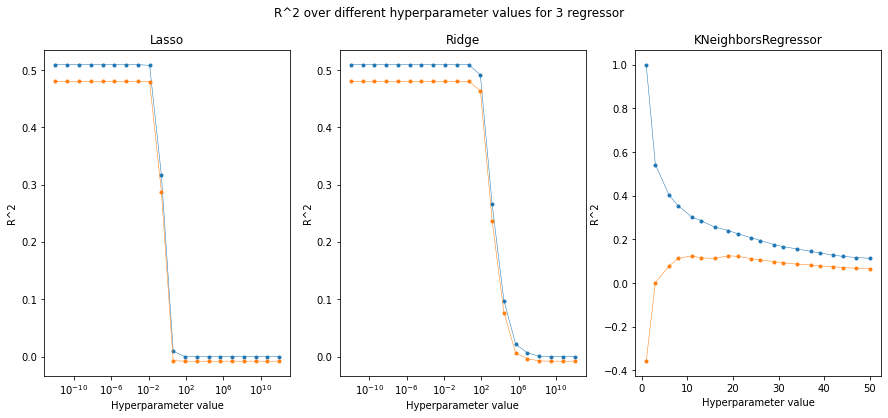

BLUE: train
ORANGE: test (validation)


In [30]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for ax in axes:
    ax.set(xlabel="Hyperparameter value", ylabel='R^2')

axes[0].set_title('Lasso')
axes[0].plot(parameters_alpha, las_scores, marker = '.')
axes[0].set_xscale("log")

axes[1].set_title('Ridge')
axes[1].plot(parameters_alpha, rid_scores, marker = '.')
axes[1].set_xscale("log")

axes[2].set_title('KNeighborsRegressor')
axes[2].plot(parameters_k, knn_scores, marker = '.')

fig.suptitle('R^2 over different hyperparameter values for 3 regressor');
plt.show()

print("BLUE: train\nORANGE: test (validation)")

# Code to print the actual values, format: list( (parameter, (train, test)) )
# print(list(zip(parameters_k, knn_scores)))

### Exercise 2.2
Interpret the plots.

* When are the methods underfitting?
 * Lasso: After alpha > 1
 * Ridge: After alpha > 100
 * kNN: When converging

* When are they overfitting?
 * Lasso: Steady fitting behavoir when optimal (alpha < 0.1)
 * Ridge: Steady fitting behavoir when optimal (alpha < 100)
 * kNN: In the beginning

* How sensitive are they to the regularization hyperparameter?

Lassa and Ridge only after certain point, knn very sensitive in general

### Exercise 2.3
ElasticNet allows to mix L1 and L2 loss, and the `l1_ratio` hyperparameter defines the ratio of L1 loss. Hence, it has two interacting hyperparameters: l1_ratio and alpha. Run a grid search to obtain a matrix of l1_ratio and alpha values and the resulting cross-validation scores. Then, use the function provided below to plot a heatmap of all values and interpret the result. Can you explain how the two hyperparameters interact?

In [31]:
# Generic heatmap
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", printvalues=False):
    """
    Plots a heatmap for the performance of a model for every combination of two hyperparameter values

    values: nxn array with all evaluation results, varying the first hyperparameter first
    xlabel: name of the first hyperparameter
    ylabel: name of the second hyperparameter
    xticklabels: values of the first hyperparameter
    yticklabels: values of the second hyperparameter
    cmap: colormap
    vmin: minimal score
    vmax: maximal score
    ax: plot axes
    fmt: format for printing the scores
    printvalues: whether to print the scores
    """
    if ax is None:
        ax = plt.gca()
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    if(printvalues):
        for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.mean(color[:3]) > 0.5:
                c = 'k'
            else:
                c = 'w'
            ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

In [32]:
# Amount of hyperparameters tested for each model
stepsize = 20

# Generate the paramater spaces according to exercise description
parameters_alpha = np.logspace(start=-12, stop=12, num=stepsize)
parameters_l1_ratio = np.linspace(start=0, stop=1, num=stepsize)

print(f"Parameters to try out: ({stepsize} in total)")
for alpha, p in zip(parameters_alpha, parameters_l1_ratio):
    print(f"alpha = {alpha:.3e}\tp = {p}")

Parameters to try out: (20 in total)
alpha = 1.000e-12	p = 0.0
alpha = 1.833e-11	p = 0.05263157894736842
alpha = 3.360e-10	p = 0.10526315789473684
alpha = 6.158e-09	p = 0.15789473684210525
alpha = 1.129e-07	p = 0.21052631578947367
alpha = 2.069e-06	p = 0.2631578947368421
alpha = 3.793e-05	p = 0.3157894736842105
alpha = 6.952e-04	p = 0.3684210526315789
alpha = 1.274e-02	p = 0.42105263157894735
alpha = 2.336e-01	p = 0.47368421052631576
alpha = 4.281e+00	p = 0.5263157894736842
alpha = 7.848e+01	p = 0.5789473684210527
alpha = 1.438e+03	p = 0.631578947368421
alpha = 2.637e+04	p = 0.6842105263157894
alpha = 4.833e+05	p = 0.7368421052631579
alpha = 8.859e+06	p = 0.7894736842105263
alpha = 1.624e+08	p = 0.8421052631578947
alpha = 2.976e+09	p = 0.894736842105263
alpha = 5.456e+10	p = 0.9473684210526315
alpha = 1.000e+12	p = 1.0


In [33]:
# Cartesian product instead of nested for-loop
# from itertools import product
# all_pairs = product(parameters_alpha, parameters_l1_ratio)

# Save the scores per model as list of: (mean_train_score, mean_test_score)
elasticnet_scores = []

for alpha in tqdm(parameters_alpha, total=stepsize):
    local_scores = []
    for p in parameters_l1_ratio:
        # Setup the model with variable hyperparameters and run evaluator
        model = ElasticNet(alpha=alpha, l1_ratio=p)
        train_scores, test_scores = evaluate_learners([model], X, y)

        # Extract the mean scores per model by computing mean of matrix-row
        # output is of form: [mean_model1, mean_model2, mean_model3]
        test_means = np.mean(test_scores, axis=1)
        local_scores.append(test_means[0])

    elasticnet_scores.append(local_scores)

100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


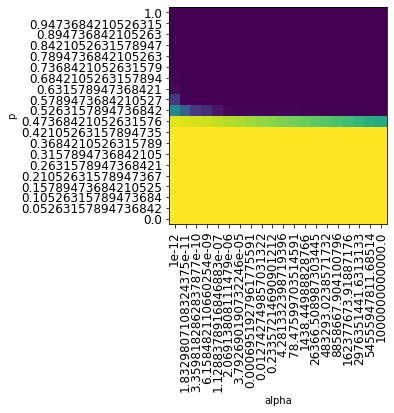

In [34]:
heatmap(
    elasticnet_scores,
    "alpha",
    "p",
    parameters_alpha,
    parameters_l1_ratio,
    cmap=None, vmin=None, vmax=None, ax=None, fmt="%0.2f", printvalues=False
)

## Exercise 3: Visualizing coefficients
Finally, let's verify whether the different optimized linear models also find the same coefficients.

### Exercise 3.1
Draw a [scatterplot](https://matplotlib.org/gallery/shapes_and_collections/scatter.html) plotting the coefficients of the different models in different colors. Do you see much difference between the different models?

For all models, choose an alpha parameter that seems to work well in the previous exercise. When in doubt, use alpha=0.001.

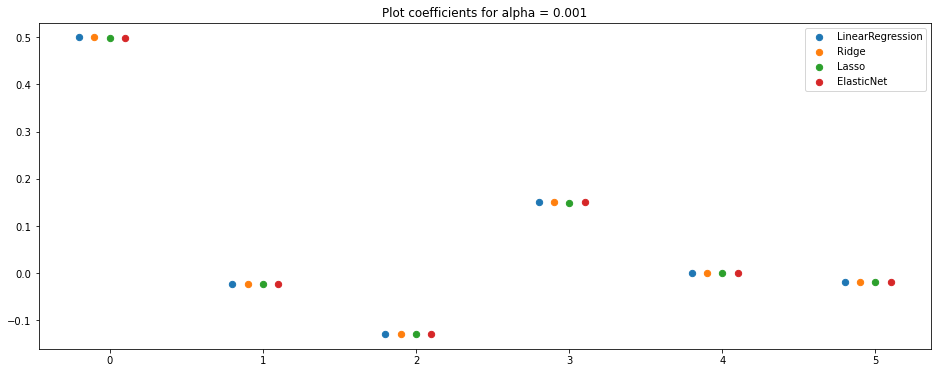

,attribute
0,cars_per_hour
1,temperature_at_2m
2,wind_speed
3,temperature_diff_2m_25m
4,wind_direction
5,hour_of_day


In [35]:
def plot_models_coefficients(alpha):
    """Plots the coefficients for different linear models on a scatter plot for comparison"""

    models = [
        LinearRegression(),
        Ridge(alpha),
        Lasso(alpha),
        ElasticNet(alpha)
    ]

    plt.figure(figsize=(16, 6))

    # For each model plot the coeffiecient on the same scatter plot with their own color
    for i, model in enumerate(models):
        model.fit(X, y)
        plt.scatter(
            # Spread out the values for different models on the x-axis with a offset
            np.arange(len(model.coef_)) + 0.1 * (i - 2),
            model.coef_,
            s = 40,
            # Infer the model name from the python class
            label=model.__class__.__name__
        )

    plt.title(f"Plot coefficients for alpha = {alpha}")
    plt.legend()
    plt.show()

    # Show the legend (not possible in plot since we want to horizontally spread the points)
    display(pd.DataFrame({"attribute": list(X)}))


plot_models_coefficients(0.001)

### Exercise 3.2
Redraw the same plot but now using a large amount of regularization (e.g. alpha=1). What do you observe? Does this help you explain the performance difference between Ridge and Lasso in exercise 1.2?

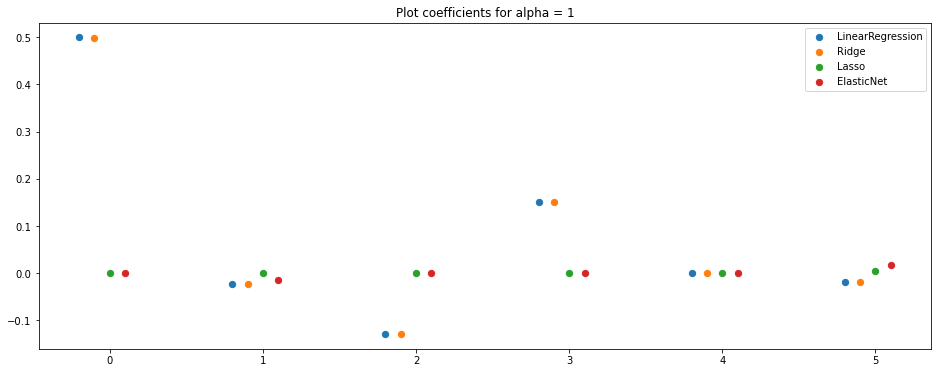

,attribute
0,cars_per_hour
1,temperature_at_2m
2,wind_speed
3,temperature_diff_2m_25m
4,wind_direction
5,hour_of_day


In [36]:
plot_models_coefficients(1)